---

# **Wind Farm Layout Optimisation**


---

## **Link to Previous Research**

This work serves as a continuation of my previous study entitled ***"Multi-Objective Optimization of Offshore Wind Farm Site Selection: A Case Study of Kaliningrad Region's EEZ"***. In that study, the focus was on the ***Macro-Scale*** problem: *determining the best general location for an offshore wind farm within a large geographical region*. The optimisation considered three primary objectives:

- ***Mean wind speed*** (to maximise energy potential),
- ***Water depth*** (to minimise foundation costs),
- ***Distance to port*** (to reduce installation and maintenance logistics).

Having identified the most suitable area within the Exclusive Economic Zone (EEZ) of the Kaliningrad Region, the current work proceeds to the next phase.

## **Micro-Scale Optimisation**

The objective now is to address the ***Micro-Scale*** problem: ***optimising the precise arrangement of wind turbines within the selected site to enhance wind capture efficiency***. 

**This involves the application of advanced wake modelling and evolutionary optimisation techniques to maximise energy output while accounting for wake effects, spacing constraints, and site-specific conditions.**

In this work, we will use **PyWake** library.


# **PyWake** https://topfarm.pages.windenergy.dtu.dk/PyWake/index.html
is an open-sourced and ***Python-based wind farm simulation tool*** developed at DTU ***capable of computing flow fields, power production of individual turbines as well as the Annual Energy Production (AEP) of a wind farm.***

It is highly efficient in calculating how the ***wake propagates*** within a wind farm and can quantify the interaction between turbines.

### **What Can PyWake Do?**
The ***main objective*** of PyWake is to ***calculate the wake interaction*** in a wind farm in a computationally inexpensive way for a range of steady state conditions. 

It is very ***useful for computing the power production of a wind farm while considering the wake losses*** for a specific wind farm layout configuration. Some of the main capabilities of PyWake that have been in constant development in the last few years include:

1. The possibility to use different engineering wake models for the simulation, such as the NOJ and Bastankhah wake deficit models.

2. The option of choosing between different sites and their wind resource, with the additional option of user-defined sites.

3. The ability to have user-defined wind turbines or import turbine files from WAsP.

4. The capability of working with chunkification and parallelization.

5. The advantage of visualizing flow maps for the wind farm layout in study.

To simulate an offshore wind farm, it is essential to define the following core components:  
1. The ***site***, which includes wind conditions and spatial layout boundaries.  
2. The ***wind turbine***, specifying its technical characteristics such as hub height, rotor diameter, and power curve.  
3. The ***wake model***, which is used to calculate the wake effects and wind speed deficits caused by turbine interactions within the farm.

## **1. Site Definition**

For the micro-scale layout optimisation, we select a specific location based on the results of the previous macro-scale optimisation stage using NSGA-3. Among the Pareto-optimal solutions identified within the Exclusive Economic Zone (EEZ) of the Kaliningrad region in the Baltic Sea, ***we choose a point with coordinates **(55.28, 20.43)** as the centre of the layout area.***

This point does not represent a single turbine location but rather defines the ***central reference of a designated site***, represented as a ***9 km² square area*** (3 km × 3 km). Within this confined area, we will optimise the spatial arrangement of turbines, ensuring the analysis remains geographically and computationally tractable.

The site-specific wind characteristics, such as wind speed distribution and predominant directions, are derived from the ***Global Wind Atlas*** and will be used as input parameters for simulation and optimisation. These characteristics will guide the wake modelling and energy yield calculations for all considered turbine positions within the defined area.

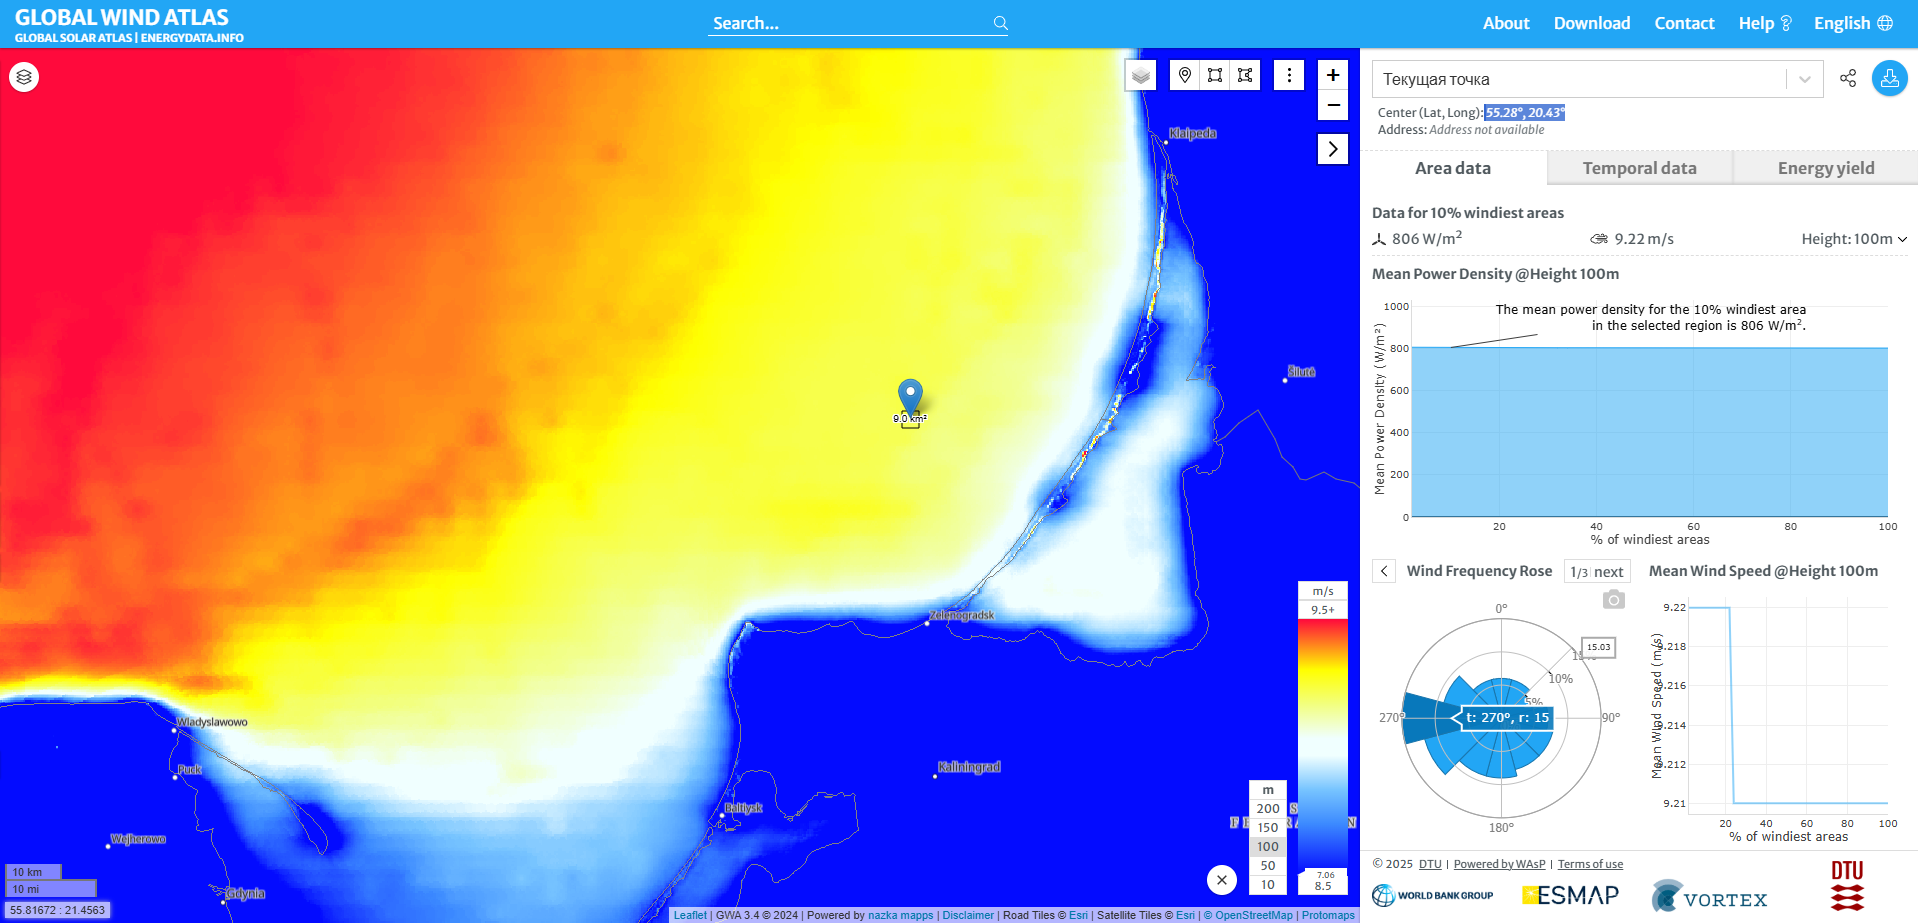

The ***`GlobalWindAtlasSite`*** class in PyWake is used to ***model wind conditions*** for a given wind farm site based on open-access data from the ***Global Wind Atlas***. By specifying the latitude, longitude, height, and roughness the class retrieves site-specific wind resource data such as ***wind speed distributions, direction probabilities, and turbulence intensity***. It provides a ready-to-use wind field for wake modelling and energy yield simulations.

In [2]:
from py_wake.site.xrsite import GlobalWindAtlasSite
import xarray as xr

# Define the parameters of the site (chosen coordinate)
latitude = 55.28           # Latitude of the location
longitude = 20.43          # Longitude of the location
height = 100               # Hub height in meters
roughness = 0.03           # Surface roughness (0.03 is typical for offshore areas)

# Create a GlobalWindAtlasSite object using the specified parameters
site = GlobalWindAtlasSite(lat=latitude, long=longitude, height=height, roughness=roughness)

# Also add TI (Tubule Intensity) = 0.1 to the dataset
site.ds['TI'] = xr.DataArray(0.1)

We can take a look at what is contained in the dataset.

In [3]:
site.ds

<xarray.Dataset> Size: 624B
Dimensions:           (wd: 13, ws: 23)
Coordinates:
  * wd                (wd) float64 104B 0.0 30.0 60.0 90.0 ... 300.0 330.0 360.0
    height            int64 8B 100
    roughness         float64 8B 0.03
  * ws                (ws) int64 184B 3 4 5 6 7 8 9 10 ... 19 20 21 22 23 24 25
Data variables:
    Weibull_A         (wd) float64 104B 8.14 7.58 7.41 8.86 ... 8.41 8.85 8.14
    Weibull_k         (wd) float64 104B 2.229 2.326 2.279 ... 2.041 1.861 2.229
    Sector_frequency  (wd) float64 104B 0.05624 0.05702 ... 0.06121 0.05624
    TI                float64 8B 0.1
Attributes:
    sector_width:  30.0

It includes:

- ***Wind directions (`wd`)***: 13 discrete direction sectors, from 0° to 360° in 30° intervals.  
- ***Wind speeds (`ws`)***: 23 wind speed bins ranging from 3 m/s to 25 m/s.  
- ***Weibull parameters***:  
  - ***`Weibull_A`*** – the scale parameter for wind directions, representing characteristic wind speeds.  
  - ***`Weibull_k`*** – the shape parameter controlling the spread of the wind distribution.  
- ***Sector frequency (`Sector_frequency`)***: Indicates the relative frequency (in fractions) of wind occurrence from directions. These values sum to 1 and reflect the site's directional wind distribution.  

Together, these variables define the statistical wind resource needed for energy production modelling, making this dataset suitable for detailed turbine layout and wake loss analysis within PyWake.

We can also generate a ***wind rose diagram*** to visually assess the predominant wind directions at the site. This graphical representation provides insight into the ***frequency distribution of wind coming from various directions***, which is essential for understanding the dominant wind patterns and optimising turbine alignment accordingly.

<xarray.DataArray (sector: 12)> Size: 96B
array([0.05692676, 0.05672759, 0.05751861, 0.07056853, 0.0876129 ,
       0.08258217, 0.08531658, 0.10119672, 0.13541968, 0.12376131,
       0.08011822, 0.06225094])
Coordinates:
  * sector   (sector) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
Attributes:
    description:  Probability of wind flow case (i.e. wind direction and wind...

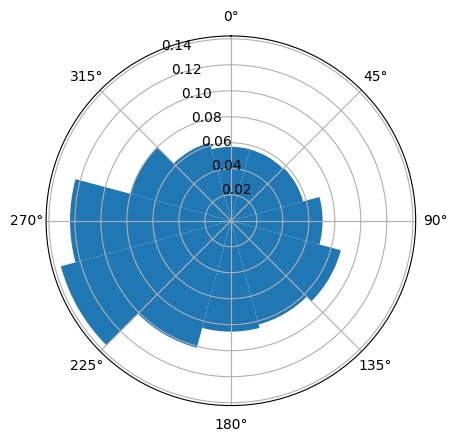

In [4]:
site.plot_wd_distribution()

We can also examine the ***wind speed distribution*** for any specific wind direction, allowing us to understand how wind speeds vary depending on the incoming flow angle.

<xarray.DataArray (wd: 1, ws: 300)> Size: 2kB
array([[5.51069329e-05, 2.03213029e-04, 3.79330946e-04, 5.72799353e-04,
        7.79260401e-04, 9.96140573e-04, 1.22167158e-03, 1.45452300e-03,
        1.69362996e-03, 1.93810084e-03, 2.18716315e-03, 2.44012968e-03,
        2.69637631e-03, 2.95532684e-03, 3.21644239e-03, 3.47921376e-03,
        3.74315592e-03, 4.00780383e-03, 4.27270947e-03, 4.53743950e-03,
        4.80157361e-03, 5.06470323e-03, 5.32643065e-03, 5.58636835e-03,
        5.84413859e-03, 6.09937311e-03, 6.35171301e-03, 6.60080872e-03,
        6.84632006e-03, 7.08791632e-03, 7.32527647e-03, 7.55808935e-03,
        7.78605390e-03, 8.00887945e-03, 8.22628599e-03, 8.43800442e-03,
        8.64377690e-03, 8.84335709e-03, 9.03651045e-03, 9.22301454e-03,
        9.40265923e-03, 9.57524702e-03, 9.74059322e-03, 9.89852618e-03,
        1.00488875e-02, 1.01915322e-02, 1.03263288e-02, 1.04531596e-02,
        1.05719205e-02, 1.06825216e-02, 1.07848865e-02, 1.08789529e-02,
        1.09646724e-02, 1.10420105e-02, 1.11109463e-02, 1.11714728e-02,
        1.12235963e-02, 1.12673368e-02, 1.13027273e-02, 1.13298138e-02,
        1.13486552e-02, 1.13593227e-02, 1.13618998e-02, 1.13564819e-02,
        1.13431759e-02, 1.13220998e-02, 1.12933826e-02, 1.12571634e-02,
        1.12135915e-02, 1.11628256e-02, 1.11050335e-02, 1.10403916e-02,
        1.09690843e-02, 1.08913037e-02, 1.08072489e-02, 1.07171257e-02,
        1.06211459e-02, 1.05195267e-02, 1.04124905e-02, 1.03002638e-02,
...
        9.24310954e-06, 8.46543911e-06, 7.74897389e-06, 7.08927928e-06,
        6.48220884e-06, 5.92388830e-06, 5.41070025e-06, 4.93926949e-06,
        4.50644907e-06, 4.10930683e-06, 3.74511271e-06, 3.41132656e-06,
        3.10558657e-06, 2.82569827e-06, 2.56962408e-06, 2.33547338e-06,
        2.12149313e-06, 1.92605896e-06, 1.74766675e-06, 1.58492467e-06,
        1.43654568e-06, 1.30134044e-06, 1.17821065e-06, 1.06614272e-06,
        9.64201925e-07, 8.71526791e-07, 7.87323921e-07, 7.10863090e-07,
        6.41472663e-07, 5.78535305e-07, 5.21483970e-07, 4.69798143e-07,
        4.23000345e-07, 3.80652859e-07, 3.42354683e-07, 3.07738696e-07,
        2.76469011e-07, 2.48238522e-07, 2.22766621e-07, 1.99797080e-07,
        1.79096083e-07, 1.60450408e-07, 1.43665737e-07, 1.28565096e-07,
        1.14987412e-07, 1.02786180e-07, 9.18282299e-08, 8.19925907e-08,
        7.31694467e-08, 6.52591710e-08, 5.81714391e-08, 5.18244127e-08,
        4.61439909e-08, 4.10631207e-08, 3.65211663e-08, 3.24633301e-08,
        2.88401219e-08, 2.56068742e-08, 2.27232972e-08, 2.01530732e-08,
        1.78634868e-08, 1.58250848e-08, 1.40113692e-08, 1.23985152e-08,
        1.09651155e-08, 9.69194680e-09, 8.56175840e-09, 7.55907922e-09,
        6.67004370e-09, 5.88223199e-09, 5.18452731e-09, 4.56698517e-09,
        4.02071492e-09, 3.53777400e-09, 3.11107044e-09, 2.73427650e-09,
        2.40174938e-09, 2.10846065e-09, 1.84993156e-09, 1.62217641e-09]])
Coordinates:
  * wd       (wd) int64 8B 0
  * ws       (ws) float64 2kB 0.05 0.15 0.25 0.35 ... 29.65 29.75 29.85 29.95

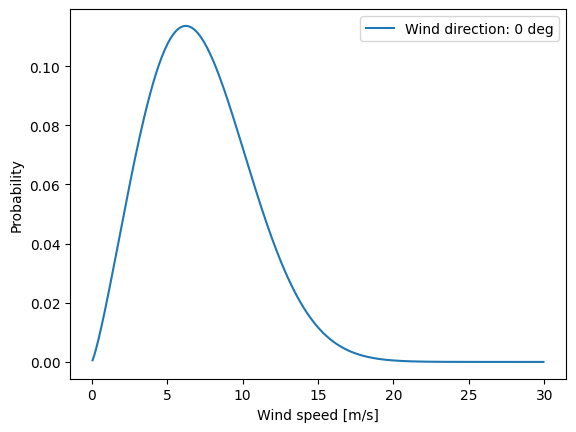

In [5]:
site.plot_ws_distribution(wd=[0])

---
## **2. Wind Turbine**

Now we need to select a wind turbine model and define its parameters.  
These parameters include:

1. ***Hub height*** (*z*): This is used to calculate the wind speed at the turbine height by applying an appropriate wind shear or vertical wind profile.  
2. ***Rotor diameter or radius*** (*D*, *R*): This value influences the amount of energy the turbine can extract from the wind and also affects the structure of the wake behind the turbine.  
3. ***Thrust coefficient*** (*Cₜ*): This turbine-specific parameter, usually provided as a function of wind speed at hub height (*v*), determines how much momentum the turbine removes from the wind. It is typically represented as a curve.  
4. ***Power curve*** (*Pₜ*): This curve describes how much electrical power the turbine produces as a function of wind speed at hub height. It incorporates the turbine's control mechanisms, such as cut-in, rated, and cut-out speeds.

In our case, we select the ***Vestas V112-3.0 MW*** wind turbine model. Below is a brief overview of the selected turbine model.

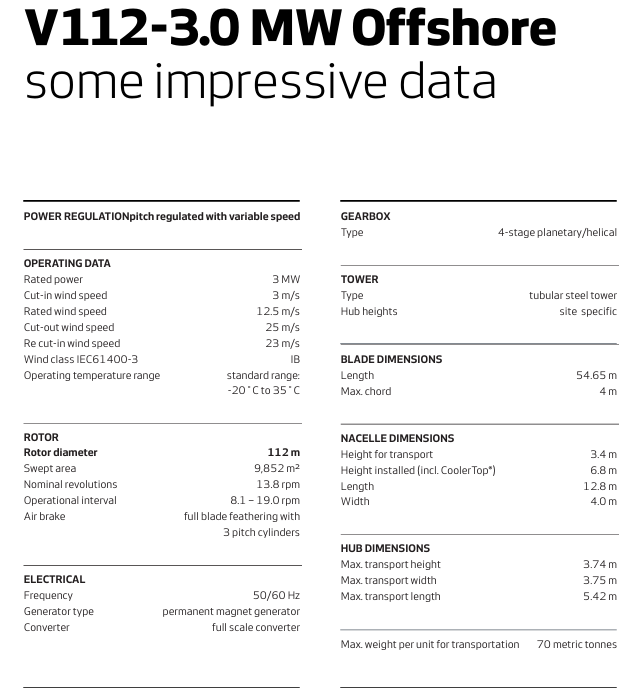


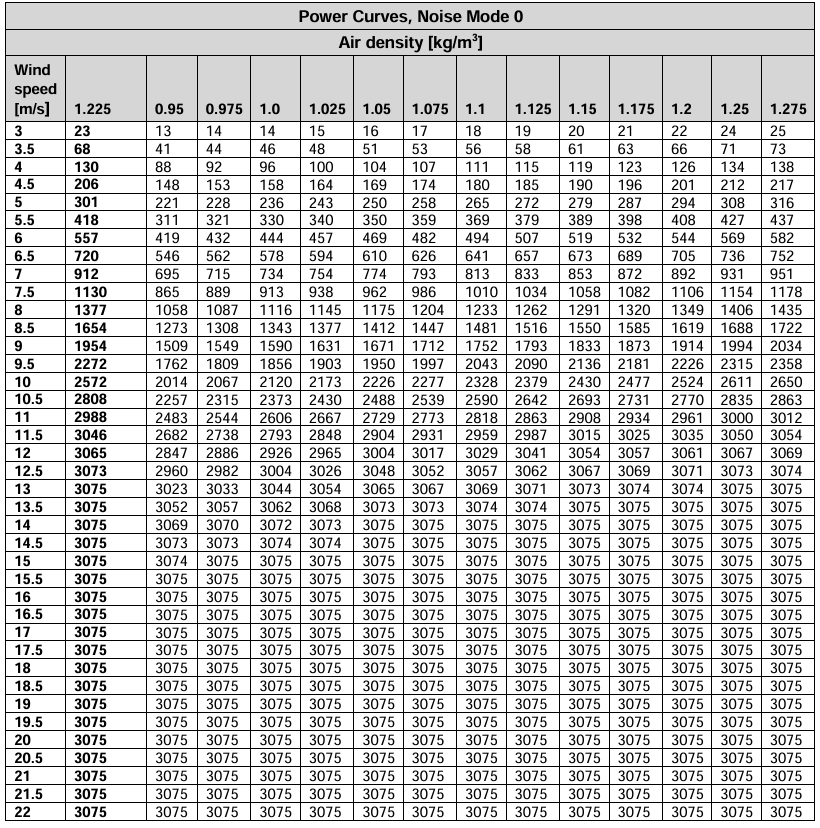

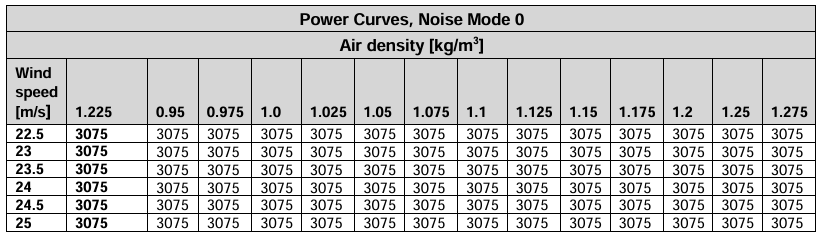

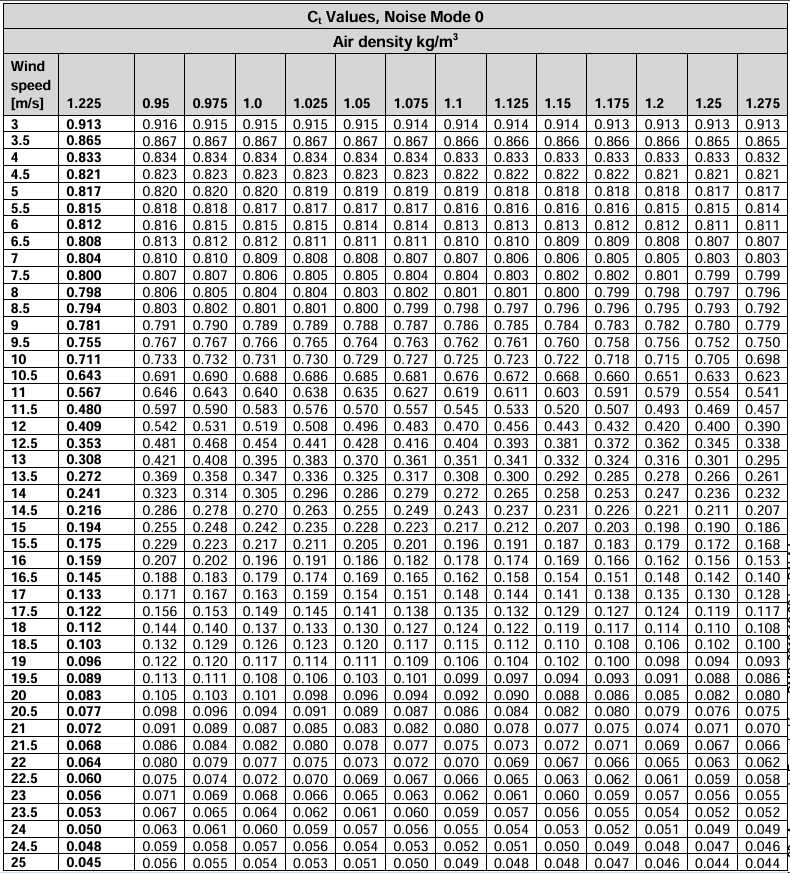

Now we need to transfer all the aforementioned turbine data into Python for further use in simulation and optimisation.

In [6]:
import numpy as np

# Wind turbine parameters
diameter = 112
hub_height = 85

wind_speeds = np.arange(3, 25.5, 0.5)

# Power curve
power = np.array([
    23, 68, 130, 206, 301, 418, 557, 720, 912, 1130, 1377, 1654, 
    1954, 2272, 2572, 2808, 2988, 3046, 3065, 3073, 3075, 3075, 
    3075, 3075, 3075, 3075, 3075, 3075, 3075, 3075, 3075, 3075, 
    3075, 3075, 3075, 3075, 3075, 3075, 3075, 3075, 3075, 3075,
    3075, 3075, 3075
]) 
# Thrust coefficients
ct = np.array([
    0.913, 0.865, 0.833, 0.821, 0.817, 0.815, 0.812, 0.808, 0.804, 
    0.800, 0.798, 0.794, 0.781, 0.755, 0.711, 0.643, 0.567, 0.480, 
    0.409, 0.353, 0.308, 0.272, 0.241, 0.216, 0.194, 0.175, 0.159, 
    0.145, 0.133, 0.122, 0.112, 0.103, 0.096, 0.089, 0.083, 0.077, 
    0.072, 0.068, 0.064, 0.060, 0.056, 0.053, 0.050, 0.048, 0.045
])

Now we define a wind turbine model using the `WindTurbine` class from the PyWake library, which is a core component in simulating wind farm performance. Specifically, we configure a ***Vestas V112-3.0 MW*** turbine by providing its physical characteristics and operational performance data.

The `WindTurbine` class requires the following key parameters:
- ***`name`***: The model name of the turbine.
- ***`diameter`***: Rotor diameter in meters.
- ***`hub_height`***: Hub height in meters.
- ***`powerCtFunction`***: An interpolation function for the turbine’s power output and thrust coefficient (`ct`) based on wind speed.


### Additional Parameters (Optional but Important)

The `WindTurbine` model in PyWake also allows for a number of ***optional parameters*** that represent physical constants and efficiency losses in the energy conversion chain. These parameters have default empirical values but can be overridden for greater modelling precision:

- ***`air_density`*** = `1.225` kg/m³: Standard air density at sea level under normal conditions.
- ***`max_cp`*** = `0.49`: Maximum power coefficient (efficiency limit of wind energy conversion).
- ***`constant_ct`*** = `0.8`: Default thrust coefficient when a fixed value is used.
- ***`gear_loss_const`*** = `0.01`: Constant gear loss (as a fraction of power).
- ***`gear_loss_var`*** = `0.014`: Variable gear loss depending on load.
- ***`generator_loss`*** = `0.03`: Fraction of power lost in the generator.
- ***`converter_loss`*** = `0.03`: Losses due to power electronics/conversion.

These parameters reflect ***mechanical and electrical efficiency*** losses during the power generation process.


In [7]:
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
from py_wake.wind_turbines import WindTurbine

Vestas = WindTurbine(name='Vestas V112-3.0 MW',
                    diameter=diameter, 
                    hub_height=hub_height, 
                    # function that interpolates power and thrust coefficient values for any wind speed
                    powerCtFunction=PowerCtTabular(wind_speeds,power,'kW',ct))

The function `Vestas.plot_power_ct()` generates a visual representation of the turbine's performance, showing how both ***power output*** and ***thrust coefficient (Ct)***.

In the resulting plot:
- The ***solid line*** represents the ***power curve***, typically measured in kilowatts (kW), showing how much electrical power the turbine produces at each wind speed.
- The ***dashed line*** represents the ***thrust coefficient (Ct)***, which quantifies the aerodynamic force exerted by the wind on the rotor.


[<Axes: title={'center': 'Vestas V112-3.0 MW'}, xlabel='Wind speed [m/s]', ylabel='Power [W]'>,
 <Axes: ylabel='Thrust coefficient'>]

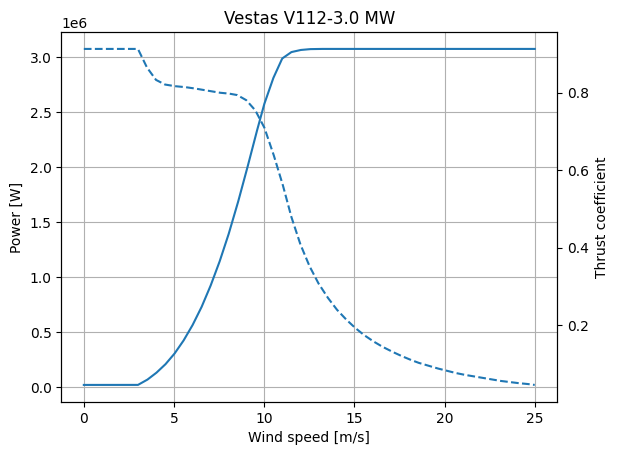

In [8]:
Vestas.plot_power_ct()

---
## **3. Wake Model**

In PyWake, the ***wake model*** plays a central role in accurately simulating the performance of wind farms. Wake models are responsible for estimating how much the ***wind speed is reduced*** behind a turbine (the ***wake deficit***) and how this reduction affects downstream turbines. These models differ in complexity, assumptions, and accuracy — and the choice of model significantly influences simulation results.

Below is an overview of ***three commonly used wake deficit models*** in PyWake, each offering a balance between computational cost and physical realism:

### **1. NOJDeficit (N. O. Jensen model)**
The ***NOJ model*** is a classic and widely used analytical wake model. It assumes a ***top-hat wake profile*** with a ***linear expansion*** of the wake downstream from the turbine.

- **Wake shape**: Uniform (top-hat)
- **Key assumption**: The wind speed deficit is uniform across the wake diameter.
- **Wake expansion**: Linear, based on a constant ***wake decay coefficient***.
- **Advantages**: Very ***fast*** and simple, suitable for preliminary analysis.
- **Limitations**: Less accurate for complex layouts, doesn't capture wake shear or realistic wake shape.

This model is useful when computational speed is prioritized over precision.

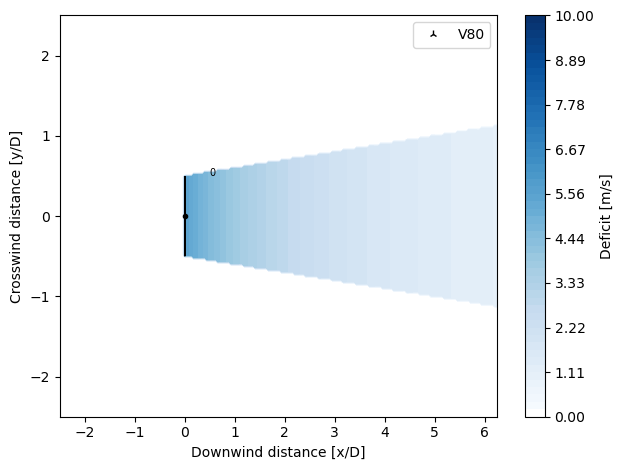

### **2. BastankhahGaussianDeficit**
The ***Bastankhah model*** (also called the ***Gaussian wake model***) is a more advanced and widely accepted analytical model that assumes a ***Gaussian-shaped wake profile***, offering better physical representation.

- **Wake shape**: Gaussian (bell curve), more realistic than top-hat
- **Includes**: Wake deflection, turbulence intensity effects, and wind shear
- **Strengths**:
  - Captures ***non-uniform wake*** more accurately
  - Based on empirical and theoretical insights from CFD studies
- **Applications**: Suitable for layout optimisation where accuracy is important
- **Computational cost**: Moderate — more expensive than NOJ but much more accurate

This model provides a good trade-off between computational efficiency and physical realism.

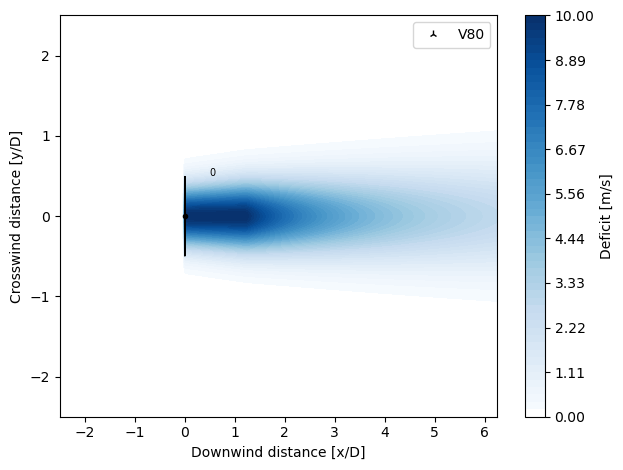

### **3. NiayifarGaussianDeficit**
The ***Niayifar model*** is also a ***Gaussian-based wake model***, but it enhances the Bastankhah model by including the ***effects of local ambient turbulence intensity*** on the rate of wake expansion and recovery.

- **Based on**: Gaussian formulation + turbulence parameterisation
- **Key feature**: Incorporates ***site-specific turbulence intensity***, which affects wake mixing
- **Suitable for**: Sites where ***turbulence varies spatially***, or where wake interaction is complex
- **Accuracy**: Higher for realistic offshore or complex terrains

Compared to the Bastankhah model, this formulation is more adaptive to environmental inputs and is considered suitable for ***site-sensitive layout optimisation***.

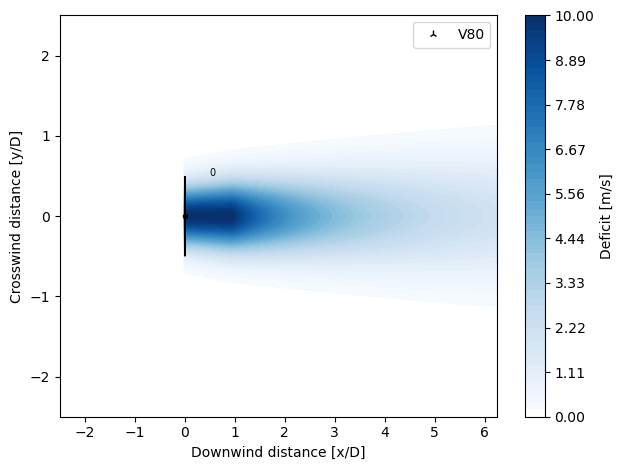

### **Comparing Wake Deficit Models**
Each wake model has different assumptions, computational cost, and realism. Selecting the appropriate model depends on the goals of the analysis:

- **NOJDeficit** is useful for quick estimations and large-scale feasibility studies.
- **BastankhahGaussianDeficit** balances performance and accuracy and is commonly used for optimisation.
- **NiayifarGaussianDeficit** is better suited for scenarios with non-uniform turbulence or when higher fidelity is required.

Below a ***comparative graph*** will be presented to visually demonstrate how these models differ in predicted wake profiles.

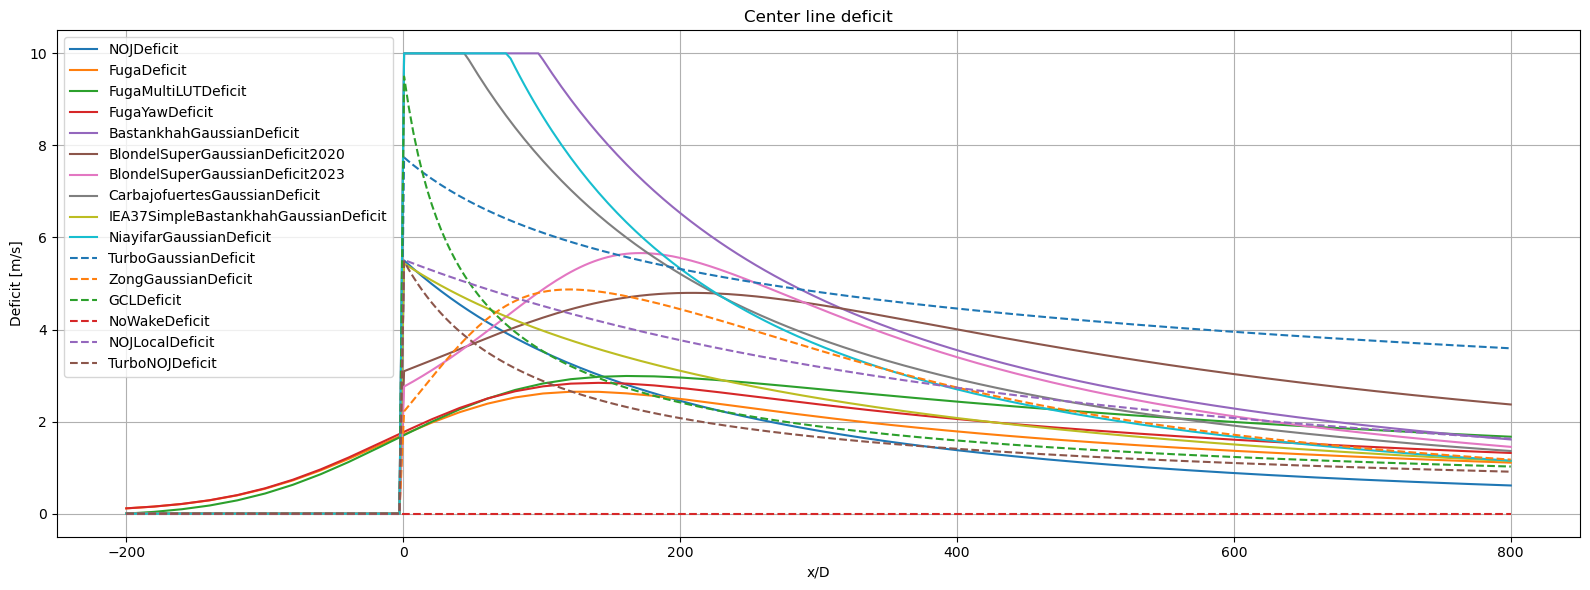

For our optimisation task, we will use the ***Jensen model***, implemented in PyWake as the `NOJDeficit`. Although it is a simplified wake model, it is computationally efficient and sufficiently accurate for our ***educational purposes***. Given the scope of this bachelor-level research the Jensen model provides a practical balance between simplicity and performance. More advanced models like `BastankhahGaussianDeficit` or `NiayifarGaussianDeficit` may offer higher fidelity but are not strictly necessary in this context.

--- 




## **Variable Neighborhood Search (VNS)** 
is a powerful and flexible ***metaheuristic*** designed to solve complex combinatorial and global optimization problems by ***systematically changing the neighborhood structures during the search process***. 

The central idea behind ***VNS*** is that a local minimum with respect to one neighborhood structure is not necessarily a local minimum with respect to another. Therefore, by ***exploring increasingly distant neighborhoods***, the algorithm can escape local optima and find better solutions. ***VNS*** operates in two key phases: ***diversification*** and ***intensification***. 

Diversification is achieved through a ***"shaking"*** process, which perturbs the current solution by applying a ***move within a neighborhood of increasing size—this helps the search jump out of local optima***. 

Intensification is carried out through a ***local search***, which ***seeks the best solution in the neighborhood of the perturbed solution***. In the context of ***Offshore Wind Farm Layout Optimization (WFLOP)***, ***VNS*** is particularly well-suited because of its ability to handle a vast number of turbines and candidate positions while respecting constraints such as minimum distances. 

The objective is to ***maximize the total energy output while minimizing wake losses***. The algorithm begins with an initial feasible layout and then iteratively improves it using VNS. The use of VNS in this setting demonstrates robust scalability and has shown to outperform traditional benchmarks in both solution quality and computational efficiency, making it a promising method for real-world wind farm design challenges.

The explanation and implementation principles of the ***Variable Neighborhood Search (VNS)*** algorithm presented here are based on the methodology described in the following papers.

**Mladenović, N., & Hansen, P. (1997). Variable neighborhood search. Computers & Operations Research, 24(11), 1097–1100. https://doi.org/10.1016/S0305-0548(97)00031-2**

**Cazzaro, D., & Pisinger, D. (2022). Variable neighborhood search for large offshore wind farm layout optimization. Computers & Operations Research, 138, 105588. https://doi.org/10.1016/j.cor.2021.105588.**


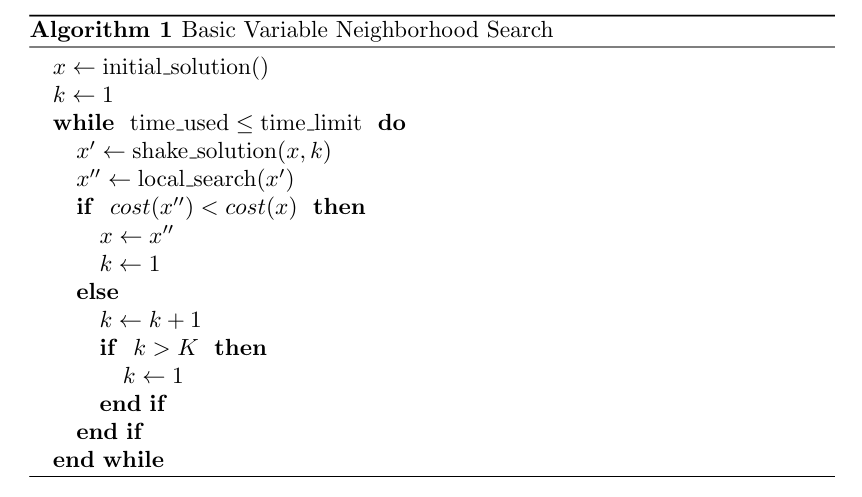

To begin, we need to define a ***set of possible locations where wind turbines can be placed within our 3×3 km² square site***. We will do this by evenly distributing candidate points across the area.

The ***center of the square*** is located at coordinates ***(55.28, 20.43)***, and the dimensions of the area are 3 km × 3 km.
The following code generates a grid of equally spaced points inside this square.

In our case, it is sufficient to generate ***5,625 candidate points***, which corresponds to a grid spacing of ***40 meters between adjacent points***. This resolution ensures a high level of flexibility in turbine layout optimization while maintaining computational efficiency.

In [9]:
import numpy as np
import pandas as pd
import geopy.distance

# 1. Define parameters
num_points_per_side = 75              # Number of points along each side
spacing_km = 0.04                     # Grid spacing in km (40 meters)
center_lat = 55.28                    # Latitude of square center
center_lon = 20.43                    # Longitude of square center

# 2. Convert km to degrees
km_to_deg_lat = 1 / 111
km_to_deg_lon = 1 / (111 * np.cos(np.radians(center_lat)))

# 3. Compute latitude and longitude offsets
lat_offsets = (np.arange(num_points_per_side) - num_points_per_side // 2) * spacing_km * km_to_deg_lat
lon_offsets = (np.arange(num_points_per_side) - num_points_per_side // 2) * spacing_km * km_to_deg_lon

# 4. Generate (lat, lon) points around the center
points = [(center_lat + dlat, center_lon + dlon) for dlat in lat_offsets for dlon in lon_offsets]
df = pd.DataFrame(points, columns=["Latitude", "Longitude"])

# 5. Convert geographic coordinates to meters (Cartesian system centered at the square center)
origin = (center_lat, center_lon)
x_meters, y_meters = [], []

for lat, lon in df[["Latitude", "Longitude"]].values:
    # North-South distance (Y-axis)
    y = geopy.distance.geodesic((lat, center_lon), origin).meters
    if lat < center_lat:
        y *= -1

    # East-West distance (X-axis)
    x = geopy.distance.geodesic((center_lat, lon), origin).meters
    if lon < center_lon:
        x *= -1

    x_meters.append(round(x, 4))
    y_meters.append(round(y, 4))

df["X"], df["Y"] = x_meters, y_meters


# 6. Output
print(df)


       Latitude  Longitude          X          Y
0     55.266667  20.406590 -1487.6277 -1484.3807
1     55.266667  20.407223 -1447.4216 -1484.3807
2     55.266667  20.407856 -1407.2154 -1484.3807
3     55.266667  20.408488 -1367.0093 -1484.3807
4     55.266667  20.409121 -1326.8031 -1484.3807
...         ...        ...        ...        ...
5620  55.293333  20.450879  1326.8031  1484.3840
5621  55.293333  20.451512  1367.0093  1484.3840
5622  55.293333  20.452144  1407.2154  1484.3840
5623  55.293333  20.452777  1447.4216  1484.3840
5624  55.293333  20.453410  1487.6277  1484.3840

[5625 rows x 4 columns]


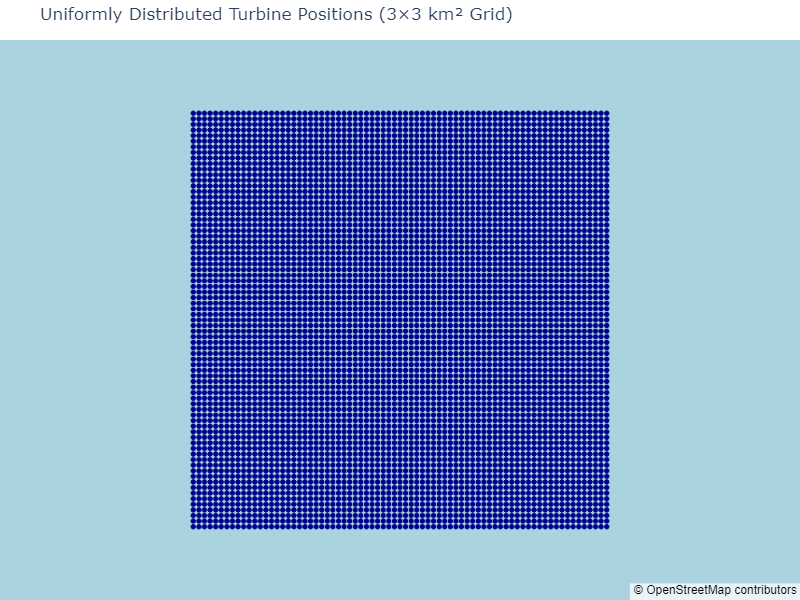

---

In [10]:
# import all necessary modules
from py_wake.deficit_models import *
from py_wake.deficit_models.deficit_model import *
from py_wake.wind_farm_models import *
from py_wake.rotor_avg_models import *
from py_wake.superposition_models import *
from py_wake.deflection_models import *
from py_wake.turbulence_models import *
from py_wake.ground_models import *
from py_wake.deficit_models.utils import *

In [11]:
# Define the site (previously created)
site = site

# Define the wind turbine model (previously created)
windTurbines = Vestas

# Define the wake deficit model (using NOJ - Jensen model with rotor averaging)
wake_deficitModel = NOJDeficit(
    k=0.0324555,  # Wake expansion coefficient (empirical parameter)
    rotorAvgModel=CGIRotorAvg(7)  # Rotor averaging model with 7 points over the rotor area
)

# Define the superposition model for wake effects
superpositionModel = SquaredSum()

# Combine all components into a Wind Farm Model (WFM) using the Downwind propagation approach
wfm = PropagateDownwind(
    site=site,
    windTurbines=windTurbines,
    wake_deficitModel=wake_deficitModel,
    superpositionModel=superpositionModel
)

# Load candidate turbine positions (X and Y coordinates) from the DataFrame
candidate_positions = df[["X", "Y"]].values

# Define the minimum distance allowed between any two turbines (4 rotor diameters)
min_distance = 4 * windTurbines.diameter()


Now we define the core functions for ***Wind Farm Layout Optimization*** using the ***Variable Neighborhood Search (VNS)*** metaheuristic. This approach enables us to intelligently explore the spatial configuration of wind turbines within a defined area to ***maximize total Annual Energy Production (AEP)*** while ensuring minimum spacing constraints.

#### **1. `initialize_positions` – Initial Placement of Turbines**
This function is responsible for generating a random initial layout of turbines. It:
- Randomly selects candidate positions from the precomputed grid (`candidate_positions`).
- Ensures that each new turbine is placed at least `min_distance` away from all previously selected turbines.
- Stops once the required number of turbines (`n_turbines`) is reached.

This serves as the ***starting point*** for the optimization process.

---

#### **2. `calculate_aep` – Annual Energy Production Computation**
This function computes the total energy yield from a given layout using PyWake’s wind farm model object (`wfm`). It:
- Extracts x and y coordinates of all turbines.
- Runs a wake simulation using wind directions ranging from ***195° to 285°*** (1° increments).
- Aggregates the total AEP using the `.aep().sum().item()` method.

The choice of wind directions based on the wind rose analysis for the selected site, we identified ***three primary wind sectors*** as having the highest frequency of wind occurrence (i.e., the greatest probability of wind flow cases). Therefore, this directional range was selected to ensure accurate and fast AEP estimation based on prevailing local wind conditions.


This metric is the ***optimization objective*** in our VNS.

---

#### **3. `local_search` – Improvement Strategy**
This function attempts to ***locally optimize*** the current layout by iteratively updating each turbine's position:
- For each turbine, it identifies candidate locations within a given ***search radius***.
- It evaluates all neighbors that do not violate the `min_distance` constraint.
- If a neighbor position yields a higher AEP, it is accepted as the new position for that turbine.

This process leads to ***local refinement*** of the layout.

---

#### **4. `shake` – Perturbation for Diversification**
The shake function introduces ***diversity*** into the solution space by randomly altering the positions of a subset of turbines:
- Randomly selects `k` turbines from the layout.
- For each selected turbine, a random neighboring position is chosen within a given radius.
- This helps escape from ***local optima*** and enhances the global search capability.

---

#### **5. `variable_neighborhood_search` – The Main Optimization Loop**
This is the orchestrating function for the full optimization process:
- Begins with a randomly initialized layout using `initialize_positions`.
- Computes its baseline AEP.
- Enters a loop of `max_iterations`, alternating between:
  - **Local improvement** using `local_search`.
  - **Diversity injection** using `shake` if no improvement is found.
- Updates the best-known layout whenever a higher AEP is achieved.

The result is a refined turbine layout, designed to extract the ***maximum possible wind energy*** from the defined site.


In [12]:
import numpy as np

# Function to randomly initialize the positions of n_turbines
# Ensures each turbine is placed at least min_distance away from others
def initialize_positions(candidate_positions, n_turbines):
    selected_positions = []
    while len(selected_positions) < n_turbines:
        candidate = candidate_positions[np.random.randint(len(candidate_positions))]
        if all(np.linalg.norm(candidate - np.array(pos)) >= min_distance for pos in selected_positions):
            selected_positions.append(candidate)
    return np.array(selected_positions)

# Function to calculate the total AEP (Annual Energy Production) for a given layout
def calculate_aep(positions, wfm=wfm):
    x_coords, y_coords = positions[:, 0], positions[:, 1]
    sim_res = wfm(x_coords, y_coords, wd=np.arange(195, 286, 1))  # wind directions from 195° to 285°
    return sim_res.aep().sum().item()

# Local Search function to improve the turbine layout within a specified neighborhood
def local_search(positions, radius, candidate_positions, min_distance=min_distance):
    new_positions = positions.copy()

    # Sort turbines by x-coordinate for consistent processing
    sorted_indices = np.argsort(new_positions[:, 0])
    new_positions = new_positions[sorted_indices]

    for i, position in enumerate(new_positions):
        best_position = position
        best_aep = calculate_aep(new_positions)

        # Find candidate neighbors within the search radius
        neighbors = [
            candidate for candidate in candidate_positions
            if np.linalg.norm(candidate - position) <= radius
        ]

        # Evaluate each neighbor
        for neighbor in neighbors:
            # Ensure new candidate does not violate min_distance constraint
            is_too_close = any(
                np.linalg.norm(neighbor - other) < min_distance
                for j, other in enumerate(new_positions) if j != i
            )
            if is_too_close:
                continue

            test_positions = new_positions.copy()
            test_positions[i] = neighbor
            new_aep = calculate_aep(test_positions)

            if new_aep > best_aep:
                best_position = neighbor
                best_aep = new_aep

        new_positions[i] = best_position

    return new_positions

# Shake function to introduce random variations to the turbine layout
def shake(positions, k, radius, candidate_positions):
    new_positions = positions.copy()
    indices = np.random.choice(range(len(new_positions)), k, replace=False)
    for index in indices:
        current_position = new_positions[index]
        neighbors = [
            candidate for candidate in candidate_positions
            if np.linalg.norm(candidate - current_position) <= radius
        ]
        if neighbors:
            new_positions[index] = neighbors[np.random.randint(len(neighbors))]
    return new_positions


# Main Variable Neighborhood Search (VNS) optimization function
def variable_neighborhood_search(n_turbines, max_iterations, initial_radius=200, max_radius=800):

    # Step 1: Initial layout
    initial_positions = initialize_positions(candidate_positions, n_turbines)
    print(f"Initial solution \n{initial_positions}")
    current_positions = initial_positions.copy()
    best_positions = current_positions.copy()
    best_aep = calculate_aep(current_positions)
    print(f"AEP before optimization: {best_aep:.2f}")
    print("-------------------------")

    k = int(n_turbines / 4)  # number of turbines to shake
    radius = initial_radius

    # Main optimization loop
    for iteration in range(max_iterations):
        print(f"Iteration {iteration + 1}")

        # Step 2: Local Search
        optimized_positions = local_search(current_positions, radius, candidate_positions)

        # Step 3: If no improvement, perform Shake
        if np.array_equal(current_positions, optimized_positions):
            radius = min(radius + 200, max_radius)
            print("-------------------------")
            print(f"Increasing radius to {radius}")
            print("-------------------------")
            optimized_positions = shake(current_positions, k, radius, candidate_positions)

        # Step 4: Evaluate new layout
        current_aep = calculate_aep(optimized_positions)

        if current_aep > best_aep:
            best_positions = optimized_positions.copy()
            best_aep = current_aep

        current_positions = optimized_positions
        print(f"Current AEP: {current_aep:.2f}")

    print("-------------------------")
    print(f"Best AEP: {best_aep:.2f}")
    return best_positions


In [13]:
# Initiaize our optimization
# It takes a lot of time and memory, so we will only perform the result of the optimization
# optimized_positions = variable_neighborhood_search(n_turbines=20, max_iterations=300)
# print("Optimized positions:")
# print(optimized_positions)


In [14]:
optimized_positions = np.array([[-1463.02510266,  1007.71946209],
 [-1377.9646985 ,  1475.55168496],
 [-1250.37409226,   114.58521844],
 [-1122.78348603,   624.94764338],
 [ -995.19287979,  1135.31006833],
 [ -782.5418694 ,  -608.4282169 ],
 [ -484.83045484,   242.17582467],
 [ -357.23984861,   752.53824962],
 [ -229.64924237,  1305.43087665],
 [   25.5319701 ,  -736.01882314],
 [  153.12257634,  -225.65639819],
 [  280.71318258,   369.76643091],
 [  365.77358673,   880.12885586],
 [  493.36419297, -1076.26043977],
 [  663.48500129,   -98.06579196],
 [  833.6058096 , -1459.03225848],
 [  961.19641584,  -948.66983353],
 [ 1088.78702207,  -438.30740859],
 [ 1301.43803247, -1331.44165224],
 [ 1429.0286387 ,  -863.60942938]])

To ensure that the turbine layout satisfies ***the minimum spacing requirement***, we visualize the positions of all 20 turbines along with a circular buffer around each one representing the `min_distance` constraint. This helps us visually confirm that turbines are placed with sufficient separation, avoiding wake interference and structural limitations.

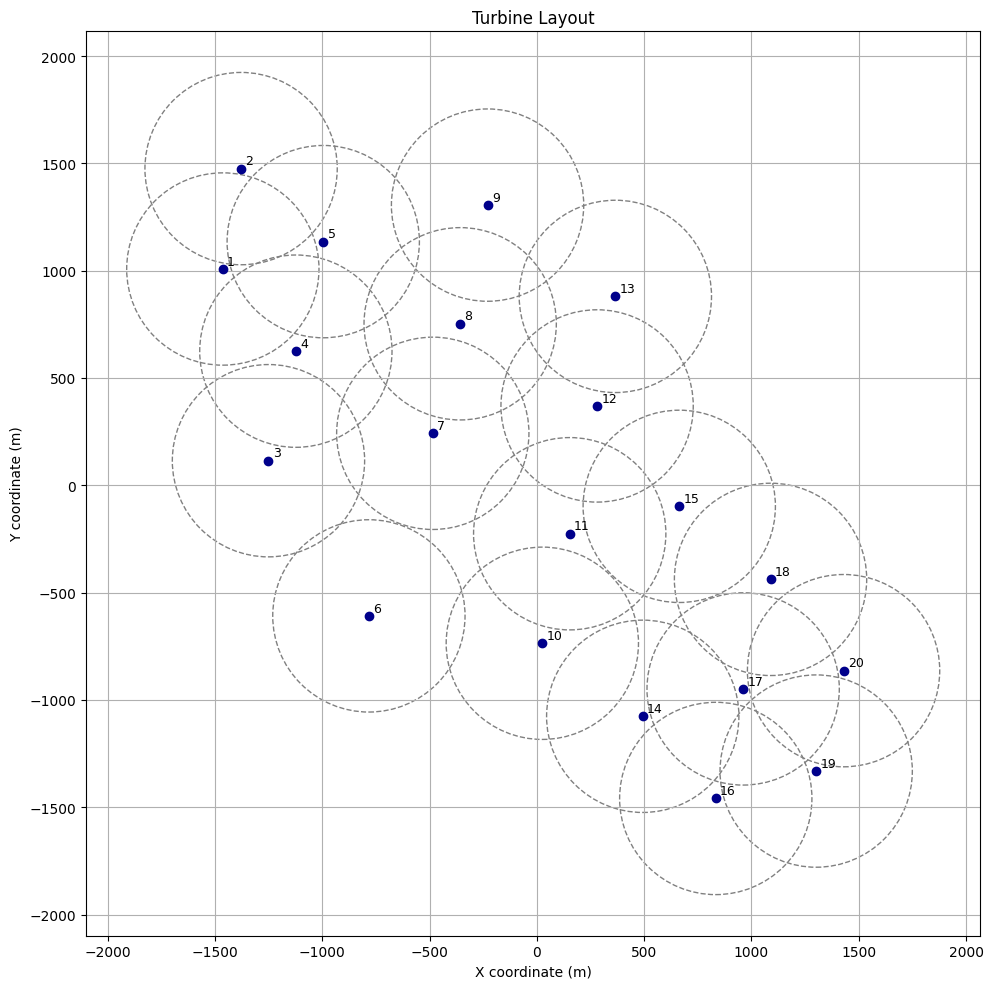

In [15]:
import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')  # Ensure equal scaling for both axes

# Plot each turbine
for i, (x, y) in enumerate(optimized_positions):
    ax.plot(x, y, 'o', color='darkblue')  # Plot turbine location
    ax.text(x + 20, y + 20, f'{i+1}', fontsize=9)  # Label each turbine with its index
    circle = plt.Circle((x, y), min_distance, color='gray', fill=False, linestyle='dashed')  # Draw min_distance circle
    ax.add_patch(circle)

# Add axis labels, title, and grid
plt.title('Turbine Layout')
plt.xlabel('X coordinate (m)')
plt.ylabel('Y coordinate (m)')
plt.grid(True)
plt.tight_layout()
plt.show()


Now we will visualize the ***wake flows*** for the ***dominant wind directions*** in this region.

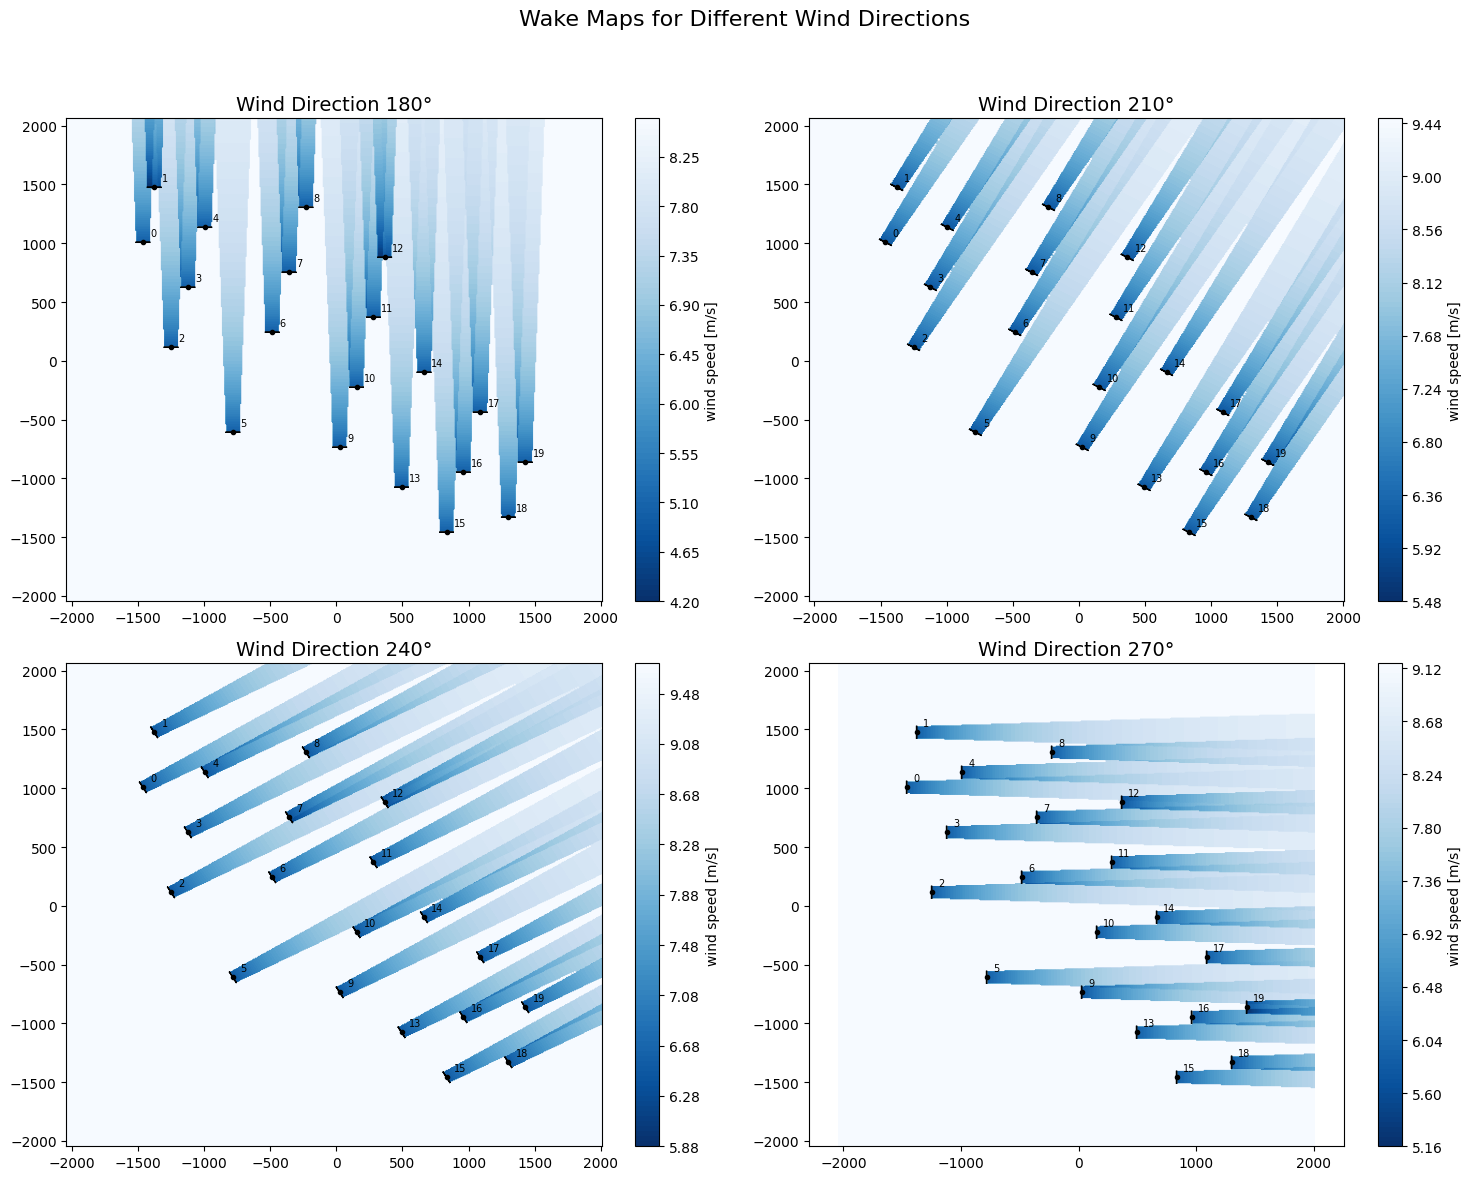

In [16]:
import matplotlib.pyplot as plt

# Run the wake simulation using the optimized turbine layout
sim_res = wfm(optimized_positions[:, 0], optimized_positions[:, 1])  # Full wake simulation (195°–285° internally)

# Define wind directions to visualize
wind_directions_viz = [180, 210, 240, 270]

# Create a 2x2 subplot grid to show wake maps for different wind directions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Loop over selected wind directions and fill subplots
for i, wd in enumerate(wind_directions_viz):
    
    row, col = divmod(i, 2)  # Determine subplot row and column index
    ax = axes[row, col]

    # Generate wake flow map for the current wind direction
    flow_map = sim_res.flow_map(wd=wd)
    flow_map.plot_wake_map(ax=ax)  # Plot the wake map on the specified axis

    ax.set_title(f"Wind Direction {wd}°", fontsize=14)

# Set the overall figure title
fig.suptitle("Wake Maps for Different Wind Directions", fontsize=16)

# Adjust layout to fit the main title
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [17]:
# Returns the total Annual Energy Production (AEP) by summing over all wind directions
sim_res.aep().sum()


<xarray.DataArray 'AEP [GWh]' ()> Size: 8B
np.float64(241.43221371572375)

In [18]:
# Returns the total AEP for wind directions specifically from 195° to 285° (inclusive)
sim_res.aep().sel(wd=np.arange(195, 286, 1)).sum()


<xarray.DataArray 'AEP [GWh]' ()> Size: 8B
np.float64(105.22758272489163)

In [19]:
# Calculates the percentage contribution of AEP from wind directions between 195° and 285° relative to the total AEP across all directions
np.round(sim_res.aep().sel(wd=np.arange(195, 286, 1)).sum().item() / sim_res.aep().sum().item() * 100, 2)


np.float64(43.58)

---
## Final Summary

***In conclusion***, we have obtained an ***optimal layout of 20 wind turbines*** for our selected offshore site, ensuring that the ***wake effects are minimized*** through intelligent spatial arrangement. The resulting configuration demonstrates a strong balance between turbine spacing and wind resource capture. Interestingly, wind directions ranging from ***195° to 285°*** — which are the most frequent in this region — contribute to ***43.58% of the total energy production***, confirming the importance of aligning the farm design with dominant wind patterns. 

Additionally, the use of the ***Variable Neighborhood Search (VNS) algorithm*** allowed for efficient exploration of the solution space, leading to a well-performing configuration under practical constraints. The wake visualizations also confirm that turbines are positioned to reduce aerodynamic interference from neighboring units. Overall, the methodology provides a scalable framework for optimizing offshore wind farms under real-world conditions.

---